In [7]:
# import necessary modules
import numpy as np
from scipy import stats
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from codonUtils import utils
from codonOptimizer import tableOptimizer
from codonTable import codonTable
import bct
import pickle
import subprocess
%load_ext autoreload

sns.set_context("poster")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
help(tableOptimizer)

Help on class tableOptimizer in module codonOptimizer:

class tableOptimizer(builtins.object)
 |  A class designed to optimize a codon table given an arbitrary objective 
 |  function to minimize/maximize
 |  
 |  Methods defined here:
 |  
 |  GDA(self, dW=None, W=0, W_stop=inf, maxIter=1000, preserveBlock=False, preserveStop=False, subFunc='minPRS')
 |      The Great Deluge Algorithm for optimizing an objective function over
 |      codon table space
 |      
 |      Parameters
 |      ----------
 |      - float dW=None: represents the rate of change (rain flux) of min
 |          allowable energy (water level); if None, initialized to 1% of
 |          cost(self.table)
 |      - float W=0: represents the initial minimal acceptable energy level
 |          (water level); defaults to 0
 |      - float W_stop=inf: represents the maximum allowable water level; stops
 |          algorithm when W > W_stop; defaults to an infinte value
 |      - int maxIter=1000: represents the maximum num

## Gathering Statistics

A set of adjacency matrices that preserve the degree, weight and strength distributions of the Standard Codon table graph were generated using bct.null_model_dir_sign() and used as a null model. A set of evolved tables were also generated and the densities of the resulting sets were compared.

In [5]:
%autoreload 2
# define number of trials to run
N = 1000
sim = tableOptimizer()
# preallocate memory for statistics
densities = np.zeros(N)
efficiencies = np.zeros(N)
clustCoeff = np.zeros(N)
modularities = np.zeros(N)
assortativities = np.zeros(N)
silencicities = np.zeros(N)
# perform N trials
for i in range(N):
    # generage graph
    ct, *dummy = sim.GDA(subFunc='Gilis')
    ct = codonTable(ct)
    Cij = ct.codonAdjMat
    # calculate statistics
    densities[i], *dummy = bct.density_und(Cij)
    efficiencies[i] = bct.efficiency_wei(Cij)
    clustCoeff[i], *dummy = bct.clustering_coef_wu(Cij)
    dummy, modularities[i] = bct.modularity_und(Cij)
    assortativities[i] = bct.assortativity_wei(Cij, 0)
    silencicities[i] = utils.silencicity(ct.codonDict)

In [ ]:
# pickle resulting statistics so they don't have to be re calculated
stats = [densities, efficiencies, clustCoeff, modularities, assortativities, silencicities]
with open('res/Gilis.pickle', 'wb') as handle:
    pickle.dump(stats, handle)

### Null Models
The null models used for this analysis preserve the in/out degree and strength of the standard codon table, but shuffle the edges. This allows for a direct comparison of any generated tables vs a set of "standard tables"

In [6]:
## Null Models
%autoreload 2
# define number of adjMats to generate
N = 10000
# get standard table
ct = codonTable()
C_st = ct.codonAdjMat
# preallocate memory for statistics
null_densities = np.zeros(N)
null_efficiencies = np.zeros(N)
null_clustCoeff = np.zeros(N)
null_modularities = np.zeros(N)
null_assortativities = np.zeros(N)
# perform N trials
for i in range(N):
    # generate new null graph
    Cij, *dummy = bct.null_model_und_sign(C_st)
    # calculate statistics
    null_densities[i], *dummy = bct.density_und(Cij)
    null_efficiencies[i] = bct.efficiency_wei(Cij)
    null_clustCoeff[i], *dummy = bct.clustering_coef_wu(Cij)
    dummy, null_modularities[i] = bct.modularity_und(Cij)
    null_assortativities[i] = bct.assortativity_wei(Cij, 0)

/home/jon/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:3162: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


In [ ]:
# pickle resulting statistics so they don't have to be re calculated
stats = [null_densities, null_efficiencies, null_clustCoeff, null_modularities, null_assortativities]
with open('res/null.pickle', 'wb') as handle:
    pickle.dump(stats, handle)

### Random Tables
A set of tables were generated randomly by using the most permissible biological block structure and maintaining at least one block per residue plus stop. This set of tables was analyzed as a benchmark against which the standard table can be compared.

In [7]:
## random Tables
%autoreload 2
# define number of trials to run
N = 100000
sim = tableOptimizer()
# preallocate memory for statistics
densities = np.zeros(N)
efficiencies = np.zeros(N)
clustCoeff = np.zeros(N)
modularities = np.zeros(N)
assortativities = np.zeros(N)
silencicities = np.zeros(N)
# perform N trials
for i in range(N):
    # generage graph
    ct = utils.randomTable()
    ct = codonTable(ct)
    Cij = ct.codonAdjMat
    # calculate statistics
    densities[i], *dummy = bct.density_und(Cij)
    efficiencies[i] = bct.efficiency_wei(Cij)
    clustCoeff[i], *dummy = bct.clustering_coef_wu(Cij)
    dummy, modularities[i] = bct.modularity_und(Cij)
    assortativities[i] = bct.assortativity_wei(Cij, 0)
    silencicities[i] = utils.silencicity(ct.codonDict)

In [4]:
# pickle resulting statistics so they don't have to be re calculated
stats = [densities, efficiencies, clustCoeff, modularities, assortativities, silencicities]
with open('res/rand.pickle', 'wb') as handle:
    pickle.dump(stats, handle)

NameError: name 'densities' is not defined

In [3]:
## Visualize the data!!

# unpickle data
with open('res/minPRS.pickle', 'rb') as handle:
    PRS_densities, PRS_efficiencies, PRS_clustCoeff, PRS_modularities, PRS_assortativities, PRS_silencicities = pickle.load(handle)

with open('res/Gilis.pickle', 'rb') as handle:
    Gilis_densities, Gilis_efficiencies, Gilis_clustCoeff, Gilis_modularities, Gilis_assortativities, Gilis_silencicities = pickle.load(handle)

with open('res/SCV.pickle', 'rb') as handle:
    SCV_densities, SCV_efficiencies, SCV_clustCoeff, SCV_modularities, SCV_assortativities, SCV_silencicities = pickle.load(handle)

with open('res/null.pickle', 'rb') as handle:
    null_densities, null_efficiencies, null_clustCoeff, null_modularities, null_assortativities = pickle.load(handle)

with open('res/rand.pickle', 'rb') as handle:
    rand_densities, rand_efficiencies, rand_clustCoeff, rand_modularities, rand_assortativities, rand_silencicities = pickle.load(handle)


## Densities

In [ ]:
# plot histograms
fig, axarr = plt.subplots(5, sharex=True)
null_weights = np.ones_like(null_densities)/float(len(null_densities))
rand_weights = np.ones_like(rand_densities)/float(len(rand_densities))
evo_weights = np.ones_like(PRS_densities)/float(len(PRS_densities))
axarr[0].hist(null_densities, 20, weights=null_weights, color='grey', alpha=0.5, label='Null')
axarr[1].hist(rand_densities, 20, weights=rand_weights, color='black', alpha=0.5, label='Random')
axarr[2].hist(PRS_densities, 20, weights=evo_weights, color='red', alpha=0.5, label='PRS')
axarr[3].hist(Gilis_densities, 20, weights=evo_weights, color='green', alpha=0.5, label='Gilis')
axarr[4].hist(SCV_densities, 20, weights=evo_weights, color='blue', alpha=0.5, label='SCV')
fig.suptitle('Histogram of Densities')
for i in range(5):
    h, l = axarr[i].get_legend_handles_labels()
    axarr[i].legend(h, l)
    axarr[i].set_ylim(0, 1)
plt.xlabel('Density')
plt.savefig('../figs/density_stats.png', bbox_inches='tight')
plt.show()

###################
## do statistics ##
###################

# test if distributions are identical to null
D_dens_rand, p_dens_rand = stats.ks_2samp(rand_densities, null_densities)
D_dens_PRS, p_dens_PRS = stats.ks_2samp(PRS_densities, null_densities)
D_dens_Gilis, p_dens_Gilis = stats.ks_2samp(Gilis_densities, null_densities)
D_dens_SCV, p_dens_SCV = stats.ks_2samp(SCV_densities, null_densities)
# test if means are different
Z_dens_rand, U_dens_rand = stats.ranksums(rand_densities, null_densities)
Z_dens_PRS, U_dens_PRS = stats.ranksums(PRS_densities, null_densities)
Z_dens_Gilis, U_dens_Gilis = stats.ranksums(Gilis_densities, null_densities)
Z_dens_SCV, U_dens_SCV = stats.ranksums(SCV_densities, null_densities)
# package into pandas dataframe for representation
index = ['KS Statistic', 'KS p-Val','Wilcoxon Z Statistic', 'Wilcoxon U-Val']
dict = {
    'Randomly Generated' : [D_dens_rand, p_dens_rand, Z_dens_rand, U_dens_rand],
    'PRS' : [D_dens_PRS, p_dens_PRS, Z_dens_PRS, U_dens_PRS],
    'Gilis' : [D_dens_Gilis, p_dens_Gilis, Z_dens_Gilis, U_dens_Gilis],
    'SCV' : [D_dens_SCV, p_dens_SCV, Z_dens_SCV, U_dens_SCV]
}
dens_stats = pd.DataFrame(dict, index=index)
dens_stats.to_html('res/dens_stats.html')


## Efficiencies

In [ ]:
# plot histograms
fig, axarr = plt.subplots(5, sharex=True)
null_weights = np.ones_like(null_efficiencies)/float(len(null_efficiencies))
rand_weights = np.ones_like(rand_efficiencies)/float(len(rand_efficiencies))
evo_weights = np.ones_like(PRS_efficiencies)/float(len(PRS_efficiencies))
axarr[0].hist(null_efficiencies, 50, weights=null_weights, color='grey', alpha=0.5, label='Null')
axarr[1].hist(rand_efficiencies, 50, weights=rand_weights, color='black', alpha=0.5, label='Random')
axarr[2].hist(PRS_efficiencies, 50, weights=evo_weights, color='red', alpha=0.5, label='PRS')
axarr[3].hist(Gilis_efficiencies, 50, weights=evo_weights, color='green', alpha=0.5, label='Gilis')
axarr[4].hist(SCV_efficiencies, 50, weights=evo_weights, color='blue', alpha=0.5, label='SCV')
fig.suptitle('Histogram of Efficiencies')
for i in range(5):
    h, l = axarr[i].get_legend_handles_labels()
    axarr[i].legend(h, l)
    axarr[i].set_ylim(0, 0.1)
plt.xlabel('Efficiency')
plt.savefig('../figs/efficiency_stats.png', bbox_inches='tight')
plt.show()

###################
## do statistics ##
###################

# test if distributions are identical to null
D_eff_rand, p_eff_rand = stats.ks_2samp(rand_efficiencies, null_efficiencies)
D_eff_PRS, p_eff_PRS = stats.ks_2samp(PRS_efficiencies, null_efficiencies)
D_eff_Gilis, p_eff_Gilis = stats.ks_2samp(Gilis_efficiencies, null_efficiencies)
D_eff_SCV, p_eff_SCV = stats.ks_2samp(SCV_efficiencies, null_efficiencies)
# test if means are different
Z_eff_rand, U_eff_rand = stats.ranksums(rand_efficiencies, null_efficiencies)
Z_eff_PRS, U_eff_PRS = stats.ranksums(PRS_efficiencies, null_efficiencies)
Z_eff_Gilis, U_eff_Gilis = stats.ranksums(Gilis_efficiencies, null_efficiencies)
Z_eff_SCV, U_eff_SCV = stats.ranksums(SCV_efficiencies, null_efficiencies)
# package into pandas dataframe for representation
index = ['KS Statistic', 'KS p-Val','Wilcoxon Z Statistic', 'Wilcoxon U-Val']
dict = {
    'Randomly Generated' : [D_eff_rand, p_eff_rand, Z_eff_rand, U_eff_rand],
    'PRS' : [D_eff_PRS, p_eff_PRS, Z_eff_PRS, U_eff_PRS],
    'Gilis' : [D_eff_Gilis, p_eff_Gilis, Z_eff_Gilis, U_eff_Gilis],
    'SCV' : [D_eff_SCV, p_eff_SCV, Z_eff_SCV, U_eff_SCV]
}
eff_stats = pd.DataFrame(dict, index=index)
eff_stats.to_html('res/eff_stats.html')


## Clustering Coefficients

In [ ]:
# plot histograms
fig, axarr = plt.subplots(5, sharex=True)
null_weights = np.ones_like(null_clustCoeff)/float(len(null_clustCoeff))
rand_weights = np.ones_like(rand_clustCoeff)/float(len(rand_clustCoeff))
evo_weights = np.ones_like(PRS_clustCoeff)/float(len(PRS_clustCoeff))
axarr[0].hist(null_clustCoeff, 50, weights=null_weights, color='grey', alpha=0.5, label='Null')
axarr[1].hist(rand_clustCoeff, 50, weights=rand_weights, color='black', alpha=0.5, label='Random')
axarr[2].hist(PRS_clustCoeff, 50, weights=evo_weights, color='red', alpha=0.5, label='PRS')
axarr[3].hist(Gilis_clustCoeff, 50, weights=evo_weights, color='green', alpha=0.5, label='Gilis')
axarr[4].hist(SCV_clustCoeff, 50, weights=evo_weights, color='blue', alpha=0.5, label='SCV')
fig.suptitle('Histogram of Clustering Coefficients')
for i in range(5):
    h, l = axarr[i].get_legend_handles_labels()
    axarr[i].legend(h, l)
    axarr[i].set_ylim(0, 0.1)
plt.xlabel('Clustering Coefficient')
#plt.savefig('../figs/density_stats.png', bbox_inches='tight')
plt.show()

###################
## do statistics ##
###################

# test if distributions are identical to null
D_clustCoeff_rand, p_clustCoeff_rand = stats.ks_2samp(rand_clustCoeff, null_clustCoeff)
D_clustCoeff_PRS, p_clustCoeff_PRS = stats.ks_2samp(PRS_clustCoeff, null_clustCoeff)
D_clustCoeff_Gilis, p_clustCoeff_Gilis = stats.ks_2samp(Gilis_clustCoeff, null_clustCoeff)
D_clustCoeff_SCV, p_clustCoeff_SCV = stats.ks_2samp(SCV_clustCoeff, null_clustCoeff)
# test if means are different
Z_clustCoeff_rand, U_clustCoeff_rand = stats.ranksums(rand_clustCoeff, null_clustCoeff)
Z_clustCoeff_PRS, U_clustCoeff_PRS = stats.ranksums(PRS_clustCoeff, null_clustCoeff)
Z_clustCoeff_Gilis, U_clustCoeff_Gilis = stats.ranksums(Gilis_clustCoeff, null_clustCoeff)
Z_clustCoeff_SCV, U_clustCoeff_SCV = stats.ranksums(SCV_clustCoeff, null_clustCoeff)
# package into pandas dataframe for representation
index = ['KS Statistic', 'KS p-Val','Wilcoxon Z Statistic', 'Wilcoxon U-Val']
dict = {
    'Randomly Generated' : [D_clustCoeff_rand, p_clustCoeff_rand, Z_clustCoeff_rand, U_clustCoeff_rand],
    'PRS' : [D_clustCoeff_PRS, p_clustCoeff_PRS, Z_clustCoeff_PRS, U_clustCoeff_PRS],
    'Gilis' : [D_clustCoeff_Gilis, p_clustCoeff_Gilis, Z_clustCoeff_Gilis, U_clustCoeff_Gilis],
    'SCV' : [D_clustCoeff_SCV, p_clustCoeff_SCV, Z_clustCoeff_SCV, U_clustCoeff_SCV]
}
clustCoeff_stats = pd.DataFrame(dict, index=index)
clustCoeff_stats.to_html('res/clustCoeff_stats.html')


## Modularities

In [ ]:
# plot histograms
fig, axarr = plt.subplots(5, sharex=True)
null_weights = np.ones_like(null_modularities)/float(len(null_modularities))
rand_weights = np.ones_like(rand_modularities)/float(len(rand_modularities))
evo_weights = np.ones_like(PRS_modularities)/float(len(PRS_modularities))
axarr[0].hist(null_modularities, 50, weights=null_weights, color='grey', alpha=0.5, label='Null')
axarr[1].hist(rand_modularities, 50, weights=rand_weights, color='black', alpha=0.5, label='Random')
axarr[2].hist(PRS_modularities, 50, weights=evo_weights, color='red', alpha=0.5, label='PRS')
axarr[3].hist(Gilis_modularities, 50, weights=evo_weights, color='green', alpha=0.5, label='Gilis')
axarr[4].hist(SCV_modularities, 50, weights=evo_weights, color='blue', alpha=0.5, label='SCV')
fig.suptitle('Histogram of Modularity metrics')
for i in range(5):
    h, l = axarr[i].get_legend_handles_labels()
    axarr[i].legend(h, l)
    axarr[i].set_ylim(0, 0.1)
plt.xlabel('Modularity Metric')
#plt.savefig('../figs/density_stats.png', bbox_inches='tight')
plt.show()

###################
## do statistics ##
###################

# test if distributions are identical to null
D_mod_rand, p_mod_rand = stats.ks_2samp(rand_modularities, null_modularities)
D_mod_PRS, p_mod_PRS = stats.ks_2samp(PRS_modularities, null_modularities)
D_mod_Gilis, p_mod_Gilis = stats.ks_2samp(Gilis_modularities, null_modularities)
D_mod_SCV, p_mod_SCV = stats.ks_2samp(SCV_modularities, null_modularities)
# test if means are different
Z_mod_rand, U_mod_rand = stats.ranksums(rand_modularities, null_modularities)
Z_mod_PRS, U_mod_PRS = stats.ranksums(PRS_modularities, null_modularities)
Z_mod_Gilis, U_mod_Gilis = stats.ranksums(Gilis_modularities, null_modularities)
Z_mod_SCV, U_mod_SCV = stats.ranksums(SCV_modularities, null_modularities)
# package into pandas dataframe for representation
index = ['KS Statistic', 'KS p-Val','Wilcoxon Z Statistic', 'Wilcoxon U-Val']
dict = {
    'Randomly Generated' : [D_mod_rand, p_mod_rand, Z_mod_rand, U_mod_rand],
    'PRS' : [D_mod_PRS, p_mod_PRS, Z_mod_PRS, U_mod_PRS],
    'Gilis' : [D_mod_Gilis, p_mod_Gilis, Z_mod_Gilis, U_mod_Gilis],
    'SCV' : [D_mod_SCV, p_mod_SCV, Z_mod_SCV, U_mod_SCV]
}
mod_stats = pd.DataFrame(dict, index=index)
mod_stats.to_html('res/mod_stats.html')


## Assortativities

In [ ]:
# plot histograms
fig, axarr = plt.subplots(5, sharex=True)
null_weights = np.ones_like(null_assortativities)/float(len(null_assortativities))
rand_weights = np.ones_like(rand_assortativities)/float(len(rand_assortativities))
evo_weights = np.ones_like(PRS_assortativities)/float(len(PRS_assortativities))
axarr[0].hist(null_assortativities, 50, weights=null_weights, color='grey', alpha=0.5, label='Null')
axarr[1].hist(rand_assortativities, 50, weights=rand_weights, color='black', alpha=0.5, label='Random')
axarr[2].hist(PRS_assortativities, 50, weights=evo_weights, color='red', alpha=0.5, label='PRS')
axarr[3].hist(Gilis_assortativities, 50, weights=evo_weights, color='green', alpha=0.5, label='Gilis')
axarr[4].hist(SCV_assortativities, 50, weights=evo_weights, color='blue', alpha=0.5, label='SCV')
fig.suptitle('Histogram of Assortativities')
for i in range(5):
    h, l = axarr[i].get_legend_handles_labels()
    axarr[i].legend(h, l)
    axarr[i].set_ylim(0, 0.15)
plt.xlabel('Assortativity')
#plt.savefig('../figs/assortativity_stats.png', bbox_inches='tight')
plt.show()

###################
## do statistics ##
###################

# test if distributions are identical to null
D_assort_rand, p_assort_rand = stats.ks_2samp(rand_assortativities, null_assortativities)
D_assort_PRS, p_assort_PRS = stats.ks_2samp(PRS_assortativities, null_assortativities)
D_assort_Gilis, p_assort_Gilis = stats.ks_2samp(Gilis_assortativities, null_assortativities)
D_assort_SCV, p_assort_SCV = stats.ks_2samp(SCV_assortativities, null_assortativities)
# test if means are different
Z_assort_rand, U_assort_rand = stats.ranksums(rand_assortativities, null_assortativities)
Z_assort_PRS, U_assort_PRS = stats.ranksums(PRS_assortativities, null_assortativities)
Z_assort_Gilis, U_assort_Gilis = stats.ranksums(Gilis_assortativities, null_assortativities)
Z_assort_SCV, U_assort_SCV = stats.ranksums(SCV_assortativities, null_assortativities)
# package into pandas dataframe for representation
index = ['KS Statistic', 'KS p-Val','Wilcoxon Z Statistic', 'Wilcoxon U-Val']
dict = {
    'Randomly Generated' : [D_assort_rand, p_assort_rand, Z_assort_rand, U_assort_rand],
    'PRS' : [D_assort_PRS, p_assort_PRS, Z_assort_PRS, U_assort_PRS],
    'Gilis' : [D_assort_Gilis, p_assort_Gilis, Z_assort_Gilis, U_assort_Gilis],
    'SCV' : [D_assort_SCV, p_assort_SCV, Z_assort_SCV, U_assort_SCV]
}
assort_stats = pd.DataFrame(dict, index=index)
assort_stats.to_html('res/assort_stats.html')


## Silencicity

Silencicity is a lab defined metric, specifying the fraction of mutations that are synonymous. Code was written that generates random codon tables, specifying the block structure, and a set of these tables were evaluated for silencicity. The Standard Table was compared to the ensemble of random tables.

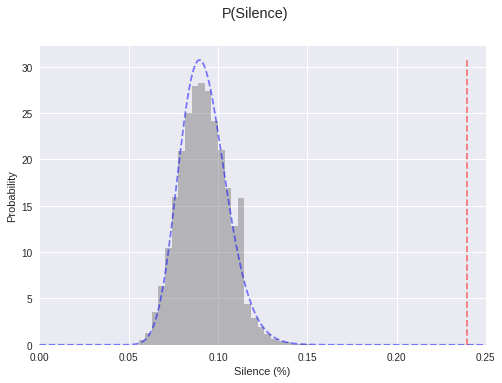

Standard Table Silencicity: 0.23958333333333334


In [4]:
# plot histograms
n, bins, patches = plt.hist(rand_silencicities, 30, color='grey', alpha=0.5, normed=1, label='Simulation')
plt.suptitle('P(Silence)')
plt.xlabel('Silence (%)')
plt.ylabel('Probability')

# fit data
s, loc, scale = stats.lognorm.fit(rand_silencicities)
x = np.linspace(0, 1, 1000)
pdf_fit = stats.lognorm.pdf(x, s, loc=loc, scale=scale)
plt.plot(x, pdf_fit, '--b', alpha=0.5, label='Fit')
#plt.xscale('log')
plt.xlim([0, 0.25])
#plot line showing standard code
ct = codonTable()
stSilencicity = utils.silencicity(ct.codonDict)
stXs = np.ones(100)*stSilencicity
stYs = np.linspace(0, max(pdf_fit), len(stXs))
plt.plot(stXs, stYs, '--r', alpha=0.5, label='Standard Code')
#plt.savefig('../figs/silencicity_stats.png', bbox_inches='tight')
plt.show()

print('Standard Table Silencicity: {0}'.format(stSilencicity))

In [102]:
# show statistics for fit
s, loc, scale

(0.13316607594862234, -0.0069656647690668457, 0.098305177965331905)

In [112]:
# calculate p value and 1 in foo of standard table silencicity
z = (stSilencicity - loc) / scale
sig = np.log(z)/s
p = 1 - math.erf(sig/np.sqrt(2))

oneInFoo = 1 / p
print('1 in {:.2e}'.format(oneInFoo))


1 in 1.99e+11


In [111]:
198895889562.8007

198895889562.8007

In [100]:
z

2.5079960507202137

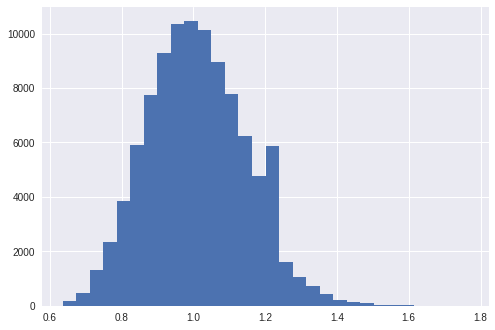

In [93]:
x_med = x[np.argmax(pdf_fit)]
y = (rand_silencicities - loc) / scale
plt.hist(y, 30)
plt.show()

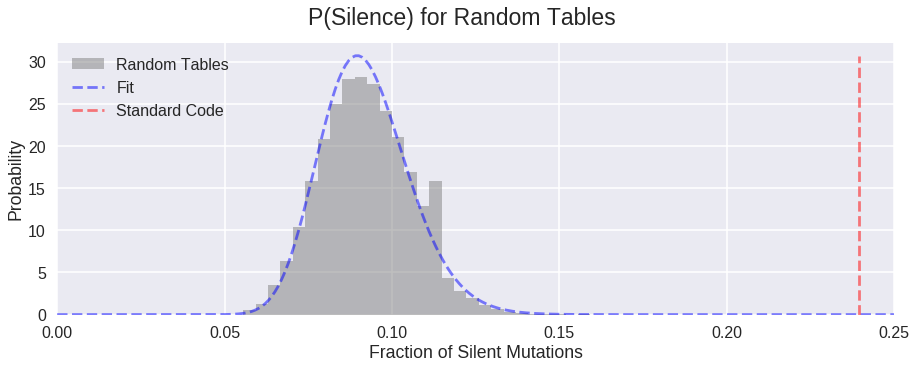

In [12]:
# faster version of Silence plot: for when the values have already been calculated
n, bins, patches = plt.hist(rand_silencicities, 30, color='grey', alpha=0.5, normed=1, label='Random Tables')
plt.suptitle('P(Silence) for Random Tables')
plt.xlabel('Fraction of Silent Mutations')
plt.ylabel('Probability')
plt.plot(x, pdf_fit, '--b', alpha=0.5, label='Fit')
#plt.xscale('log')
#plot line showing standard code
ct = codonTable()
stSilencicity = utils.silencicity(ct.codonDict)
stXs = np.ones(100)*stSilencicity
stYs = np.linspace(0, max(pdf_fit), len(stXs))
plt.plot(stXs, stYs, '--r', alpha=0.5, label='Standard Code')
plt.xlim([0, 0.25])
fig = plt.gcf()
ax = plt.gca()
h, l = ax.get_legend_handles_labels()
h = [h[-1], h[0], h[1]]
l = [l[-1], l[0], l[1]]
ax.legend(h, l)
fig.set_size_inches(15,5)
plt.savefig('../../Presentations/BioE_Retreat_2017/figs/silencicity_stats.png', bbox_inches='tight', dpi=300)
plt.show()